In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from models.NeuralNetwork import NeuralNetwork
from models.graphics import visualise_board

In [2]:
filename = "adult.csv"
data = read_csv(filename,delimiter=",", na_values="?")

#class_counts = data.groupby('income').size()
#print(class_counts)

"""
Imputation
"""
null_columns =['workclass','occupation','native.country']
for i in null_columns:
    data.fillna(data[i].mode()[0], inplace=True)
    
"""
Factorize
"""  
data['income'] = data['income'].replace({'<=50K':0, '>50K':1})
data['sex'] = data['sex'].replace({'Female':0, 'Male':1})
data['race'] = data['race'].replace({'White':0, 'Black':1, 'Asian-Pac-Islander':2, 'Other':3,'Amer-Indian-Eskimo':4})
data['workclass'] = data['workclass'].replace({'Private':0, 'State-gov':1, 'Federal-gov':2, 'Self-emp-not-inc':3,
       'Self-emp-inc':4, 'Local-gov':5, 'Without-pay':6, 'Never-worked':7})
data['native.country'] = data['native.country'].replace({'United-States':0, 'Private':1, 'Mexico':2, 'Greece':3, 'Vietnam':4, 'China':5,
       'Taiwan':6, 'India':7, 'Philippines':8, 'Trinadad&Tobago':9, 'Canada':10,
       'South':11, 'Holand-Netherlands':12, 'Puerto-Rico':13, 'Poland':14, 'Iran':15,
       'England':16, 'Germany':17, 'Italy':18, 'Japan':19, 'Hong':20, 'Honduras':21, 'Cuba':22,
       'Ireland':23, 'Cambodia':24, 'Peru':25, 'Nicaragua':26, 'Dominican-Republic':27,
       'Haiti':28, 'El-Salvador':29, 'Hungary':30, 'Columbia':31, 'Guatemala':32,
       'Jamaica':33, 'Ecuador':34, 'France':35, 'Yugoslavia':36, 'Scotland':37,
       'Portugal':38, 'Laos':39, 'Thailand':40, 'Outlying-US(Guam-USVI-etc)':41})
data['occupation'] = data['occupation'].replace({'Private':0, 'Exec-managerial':1, 'Machine-op-inspct':2,
       'Prof-specialty':3, 'Other-service':4, 'Adm-clerical':5, 'Craft-repair':6,
       'Transport-moving':7, 'Handlers-cleaners':8, 'Sales':9,
       'Farming-fishing':10, 'Tech-support':11, 'Protective-serv':12,
       'Armed-Forces':13, 'Priv-house-serv':14})
data['relationship'] = data['relationship'].replace({'Not-in-family':0, 'Unmarried':1, 'Own-child':2, 'Other-relative':3,
       'Husband':4, 'Wife':5})
data['education'] = data['education'].replace({'HS-grad':0, 'Some-college':1, '7th-8th':2, '10th':3, 'Doctorate':4,
       'Prof-school':5, 'Bachelors':6, 'Masters':7, '11th':8, 'Assoc-acdm':9,
       'Assoc-voc':10, '1st-4th':11, '5th-6th':12, '12th':13, '9th':14, 'Preschool':15})
data['marital.status'] = data['marital.status'].replace(['Never-married', 'Divorced', 'Separated', 'Widowed'], 'Single')
data['marital.status'] = data['marital.status'].replace(['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 'Married')
data['marital.status'] = data['marital.status'].map({'Married':1, 'Single':0})


X = data.iloc[:,:14]
y = data.iloc[:,14]

"""
Undersample
"""  
undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(X,y)

"""
Scaling
""" 
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX = scaler.fit_transform(X)

"""
Splitting
"""

X_train, X_test, y_train, y_test = train_test_split(rescaledX,y.to_numpy(),test_size=0.2, random_state=1)


In [3]:
def sample_batch(data,batch_size):
    st_batch = data.shape[0] // batch_size
    idx_end = st_batch * batch_size
    batch = np.split(data[:idx_end], st_batch)
    
    if data.shape[0] % batch_size != 0:
        batch += [data[idx_end:]]
    
    return batch

In [4]:


def ml_model(X_train, y_train, model, optimizer, opt_attr, batch_size = 128, epochs = 100, folds = 10):
    
    splits = StratifiedKFold(n_splits = folds, shuffle = True)
    
    log = []
    it = 1
    for fold, (train_idx, valid_idx) in enumerate(splits.split(X_train, y_train)):
        print("\nFold:", fold+1)
                    
        X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
        X_valid_fold, y_valid_fold = X_train[valid_idx], y_train[valid_idx]

        for t in range(epochs):
        
            train_loss, train_acc = [], []
            valid_loss, valid_acc = [], []  

            X_t_batch = sample_batch(X_train_fold, batch_size)
            y_t_batch = sample_batch(y_train_fold, batch_size)

            X_v_batch = sample_batch(X_valid_fold, batch_size)
            y_v_batch = sample_batch(y_valid_fold, batch_size)

            for Xs, ys in zip(X_t_batch, y_t_batch):
                                
                nn.forward(Xs)
                _, running_loss = nn.b_cross_entropy(ys, nn.A3)
                train_loss.append(running_loss)
                
                _, _, running_acc = nn.predict(Xs,ys)
                train_acc.append(running_acc)
                
                nn.backward(ys, nn.db_cross_entropy)
                optimizer(attr=opt_attr)

            
            epoch_train_loss = sum(train_loss) / len(train_loss)
            epoch_train_acc = sum(train_acc) / len(train_acc)
            
            
           
            for Xs, ys in zip(X_v_batch, y_v_batch):            
                
                probs, _, running_acc = nn.predict(Xs,ys)
                _, running_loss = nn.b_cross_entropy(ys, probs)
                valid_loss.append(running_loss)
                valid_acc.append(running_acc)
             
            epoch_valid_loss = sum(valid_loss) / len(valid_loss)
            epoch_valid_acc = sum(valid_acc) / len(valid_acc)
            
            if t % 2 == 0:
                print("Epoch: {:02d} - Loss: {:.4f} - Acc: {:.4f} - ".format(t, epoch_train_loss, epoch_train_acc), end="")
                print("Val_Loss: {:.4f} - Val_Acc: {:.4f}".format(epoch_valid_loss, epoch_valid_acc))  
            
            log.append([it, epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc])
            it += 1
    return pd.DataFrame(log, columns=["epochs","T Loss","T Accuracy","V Loss", "V Accuracy"])
            
            

In [5]:
nn = NeuralNetwork(input_size = X.shape[1], hidden_layer_size = 3, output_size = 1) 

log = ml_model(X_train, y_train, 
                model=nn, 
                optimizer=nn.gd, 
                opt_attr = {"lr":0.01},
                batch_size = 128,
                epochs = 10,
                folds = 7)

_, prediction, accuracy = nn.predict(X_test,y_test)
print("\nAccuracy on test set {:.2f}%".format(accuracy))


Fold: 1
Epoch: 00 - Loss: 0.5685 - Acc: 74.7210 - Val_Loss: 0.5085 - Val_Acc: 77.5521
Epoch: 02 - Loss: 0.4775 - Acc: 76.8136 - Val_Loss: 0.4539 - Val_Acc: 80.9375
Epoch: 04 - Loss: 0.4547 - Acc: 78.2831 - Val_Loss: 0.4326 - Val_Acc: 82.1354
Epoch: 06 - Loss: 0.4453 - Acc: 78.8132 - Val_Loss: 0.4268 - Val_Acc: 82.6042
Epoch: 08 - Loss: 0.4389 - Acc: 79.0179 - Val_Loss: 0.4239 - Val_Acc: 82.9688

Fold: 2
Epoch: 00 - Loss: 0.4243 - Acc: 80.1930 - Val_Loss: 0.4298 - Val_Acc: 79.9665
Epoch: 02 - Loss: 0.4213 - Acc: 80.3860 - Val_Loss: 0.4270 - Val_Acc: 79.9665
Epoch: 04 - Loss: 0.4187 - Acc: 80.4596 - Val_Loss: 0.4248 - Val_Acc: 80.1339
Epoch: 06 - Loss: 0.4166 - Acc: 80.4044 - Val_Loss: 0.4229 - Val_Acc: 80.2455
Epoch: 08 - Loss: 0.4147 - Acc: 80.4871 - Val_Loss: 0.4213 - Val_Acc: 80.2455

Fold: 3
Epoch: 00 - Loss: 0.4130 - Acc: 80.4504 - Val_Loss: 0.4229 - Val_Acc: 80.4129
Epoch: 02 - Loss: 0.4114 - Acc: 80.4412 - Val_Loss: 0.4220 - Val_Acc: 80.4129
Epoch: 04 - Loss: 0.4103 - Acc: 80.46

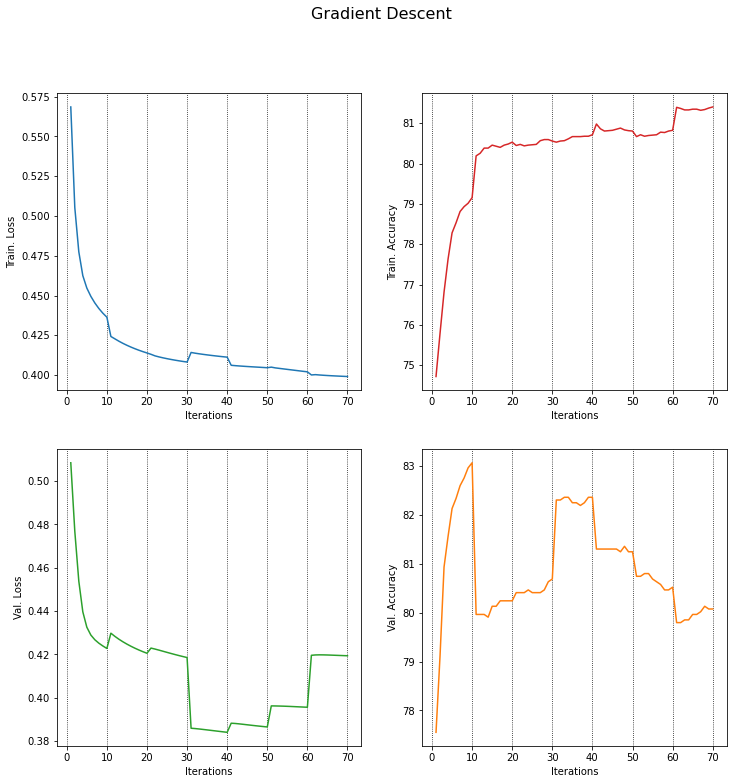

In [6]:
visualise_board(log, "Gradient Descent")

In [7]:
nn = NeuralNetwork(input_size = X.shape[1], hidden_layer_size = 3, output_size = 1) 

log = ml_model(X_train, y_train, 
                model=nn, 
                optimizer=nn.gd_m, 
                opt_attr = {"lr":0.01,"decay":0.9},
                batch_size = 128,
                epochs = 10,
                folds = 7)

_, prediction, accuracy = nn.predict(X_test,y_test)
print("\nAccuracy on test set {:.2f}%".format(accuracy))


Fold: 1
Epoch: 00 - Loss: 0.5365 - Acc: 72.5353 - Val_Loss: 0.4113 - Val_Acc: 80.9375
Epoch: 02 - Loss: 0.4336 - Acc: 79.3713 - Val_Loss: 0.4003 - Val_Acc: 81.5104
Epoch: 04 - Loss: 0.4225 - Acc: 79.8735 - Val_Loss: 0.3924 - Val_Acc: 82.1875
Epoch: 06 - Loss: 0.4178 - Acc: 80.1525 - Val_Loss: 0.3913 - Val_Acc: 82.0833
Epoch: 08 - Loss: 0.4148 - Acc: 80.3199 - Val_Loss: 0.3914 - Val_Acc: 81.6146

Fold: 2
Epoch: 00 - Loss: 0.4122 - Acc: 80.4688 - Val_Loss: 0.4052 - Val_Acc: 81.6406
Epoch: 02 - Loss: 0.4107 - Acc: 80.4044 - Val_Loss: 0.4111 - Val_Acc: 81.2500
Epoch: 04 - Loss: 0.4090 - Acc: 80.5699 - Val_Loss: 0.4095 - Val_Acc: 81.3058
Epoch: 06 - Loss: 0.4074 - Acc: 80.6066 - Val_Loss: 0.4074 - Val_Acc: 80.9710
Epoch: 08 - Loss: 0.4059 - Acc: 80.6618 - Val_Loss: 0.4051 - Val_Acc: 81.3616

Fold: 3
Epoch: 00 - Loss: 0.4030 - Acc: 81.4154 - Val_Loss: 0.4007 - Val_Acc: 80.5804
Epoch: 02 - Loss: 0.4033 - Acc: 81.2776 - Val_Loss: 0.4006 - Val_Acc: 80.7478
Epoch: 04 - Loss: 0.4025 - Acc: 81.36

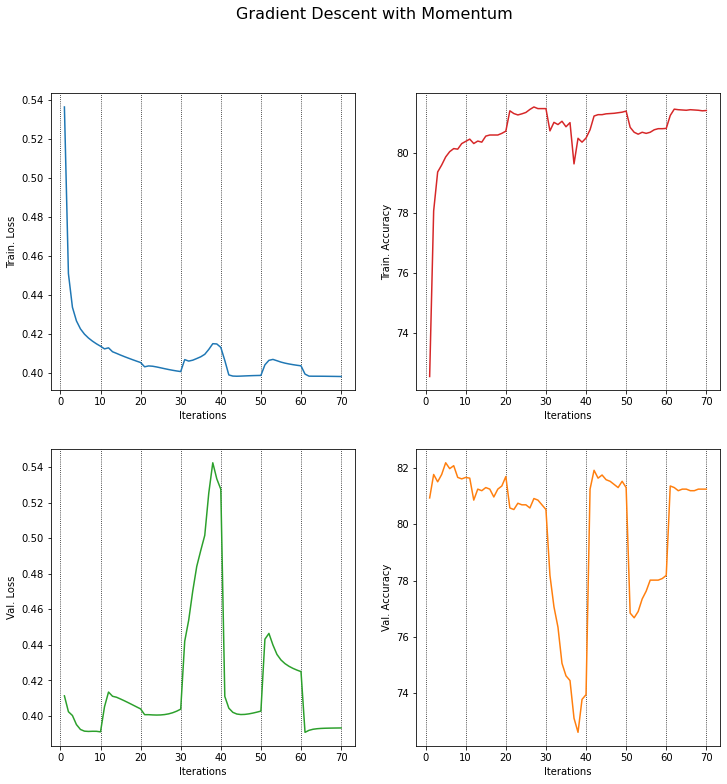

In [8]:
visualise_board(log, "Gradient Descent with Momentum")

In [9]:
# Rprop -- No mini-batches!

nn = NeuralNetwork(input_size = X.shape[1], hidden_layer_size = 3, output_size = 1) 

log = ml_model(X_train, y_train, 
                model=nn, 
                optimizer=nn.rprop, 
                opt_attr = {"inc":1.2, "dec":0.5, "step_sizes":(0.0001,50)},
                batch_size = 128,
                epochs = 10,
                folds = 7)

_, prediction, accuracy = nn.predict(X_test,y_test)
print("\nAccuracy on test set {:.2f}%".format(accuracy))


Fold: 1
Epoch: 00 - Loss: 0.6009 - Acc: 49.9163 - Val_Loss: 0.6029 - Val_Acc: 46.6146
Epoch: 02 - Loss: 0.5819 - Acc: 49.9349 - Val_Loss: 0.5996 - Val_Acc: 46.6146


/Users/art/Documents/ML/Coursework/NeuralNetwork/models/NeuralNetwork.py:67: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-s))


Epoch: 04 - Loss: 0.5790 - Acc: 49.9349 - Val_Loss: 0.5964 - Val_Acc: 46.6146
Epoch: 06 - Loss: 0.5763 - Acc: 49.9349 - Val_Loss: 0.5933 - Val_Acc: 46.6146
Epoch: 08 - Loss: 0.5736 - Acc: 49.9349 - Val_Loss: 0.5903 - Val_Acc: 46.6146

Fold: 2
Epoch: 00 - Loss: 0.5745 - Acc: 49.3566 - Val_Loss: 0.5668 - Val_Acc: 49.8884
Epoch: 02 - Loss: 0.5718 - Acc: 74.0533 - Val_Loss: 0.5643 - Val_Acc: 75.7254
Epoch: 04 - Loss: 0.5691 - Acc: 76.4890 - Val_Loss: 0.5618 - Val_Acc: 76.3393
Epoch: 06 - Loss: 0.5665 - Acc: 76.7923 - Val_Loss: 0.5593 - Val_Acc: 76.4509
Epoch: 08 - Loss: 0.5640 - Acc: 76.8842 - Val_Loss: 0.5568 - Val_Acc: 76.6183

Fold: 3
Epoch: 00 - Loss: 0.5623 - Acc: 76.9669 - Val_Loss: 0.5496 - Val_Acc: 77.2321
Epoch: 02 - Loss: 0.5598 - Acc: 77.0680 - Val_Loss: 0.5472 - Val_Acc: 77.3438
Epoch: 04 - Loss: 0.5573 - Acc: 77.2151 - Val_Loss: 0.5449 - Val_Acc: 77.3438
Epoch: 06 - Loss: 0.5549 - Acc: 77.2886 - Val_Loss: 0.5426 - Val_Acc: 77.3996
Epoch: 08 - Loss: 0.5526 - Acc: 77.3162 - Val_

In [10]:
nn = NeuralNetwork(input_size = X.shape[1], hidden_layer_size = 3, output_size = 1) 

log = ml_model(X_train, y_train, 
                model=nn, 
                optimizer=nn.rmsprop, 
                opt_attr = {"lr":0.01, "decay":0.9, "eps":0.0001},
                batch_size = 128,
                epochs = 10,
                folds = 7)

_, prediction, accuracy = nn.predict(X_test,y_test)
print("\nAccuracy on test set {:.2f}%".format(accuracy))


Fold: 1
Epoch: 00 - Loss: 0.5919 - Acc: 73.1399 - Val_Loss: 0.5188 - Val_Acc: 77.3958
Epoch: 02 - Loss: 0.5045 - Acc: 75.5859 - Val_Loss: 0.4635 - Val_Acc: 77.7083
Epoch: 04 - Loss: 0.5025 - Acc: 75.6975 - Val_Loss: 0.4703 - Val_Acc: 77.8646
Epoch: 06 - Loss: 0.5017 - Acc: 76.6276 - Val_Loss: 0.4614 - Val_Acc: 79.4792
Epoch: 08 - Loss: 0.4923 - Acc: 76.7578 - Val_Loss: 0.4404 - Val_Acc: 80.0000

Fold: 2
Epoch: 00 - Loss: 0.4667 - Acc: 77.6011 - Val_Loss: 0.4517 - Val_Acc: 79.7433
Epoch: 02 - Loss: 0.4704 - Acc: 77.7849 - Val_Loss: 0.4349 - Val_Acc: 80.3013
Epoch: 04 - Loss: 0.4404 - Acc: 78.9338 - Val_Loss: 0.4264 - Val_Acc: 80.6920
Epoch: 06 - Loss: 0.4470 - Acc: 78.6949 - Val_Loss: 0.4211 - Val_Acc: 81.3058
Epoch: 08 - Loss: 0.4362 - Acc: 79.0165 - Val_Loss: 0.4232 - Val_Acc: 81.1942

Fold: 3
Epoch: 00 - Loss: 0.4302 - Acc: 79.8897 - Val_Loss: 0.4174 - Val_Acc: 81.3616
Epoch: 02 - Loss: 0.4314 - Acc: 79.9816 - Val_Loss: 0.4087 - Val_Acc: 82.3103
Epoch: 04 - Loss: 0.4224 - Acc: 80.65

In [11]:
# Adam -- number of iterations

nn = NeuralNetwork(input_size = X.shape[1], hidden_layer_size = 3, output_size = 1) 
nn.t = 1

log = ml_model(X_train, y_train, 
                model=nn, 
                optimizer=nn.adam, 
                opt_attr = {"lr":0.01, "b":(0.9,0.999), "eps":0.0001},
                batch_size = 128,
                epochs = 10,
                folds = 7)

_, prediction, accuracy = nn.predict(X_test,y_test)
print("\nAccuracy on test set {:.2f}%".format(accuracy))


Fold: 1
Epoch: 00 - Loss: 0.5983 - Acc: 73.1213 - Val_Loss: 0.5386 - Val_Acc: 77.7083
Epoch: 02 - Loss: 0.4976 - Acc: 76.4974 - Val_Loss: 0.4812 - Val_Acc: 78.5938
Epoch: 04 - Loss: 0.4685 - Acc: 77.4554 - Val_Loss: 0.4543 - Val_Acc: 79.6354
Epoch: 06 - Loss: 0.4511 - Acc: 78.4505 - Val_Loss: 0.4365 - Val_Acc: 80.2604
Epoch: 08 - Loss: 0.4395 - Acc: 79.2783 - Val_Loss: 0.4239 - Val_Acc: 81.3021

Fold: 2
Epoch: 00 - Loss: 0.4295 - Acc: 79.6967 - Val_Loss: 0.4257 - Val_Acc: 80.3013
Epoch: 02 - Loss: 0.4231 - Acc: 80.0919 - Val_Loss: 0.4212 - Val_Acc: 80.5804
Epoch: 04 - Loss: 0.4183 - Acc: 80.3860 - Val_Loss: 0.4178 - Val_Acc: 80.5804
Epoch: 06 - Loss: 0.4146 - Acc: 80.6250 - Val_Loss: 0.4152 - Val_Acc: 80.9710
Epoch: 08 - Loss: 0.4117 - Acc: 80.8456 - Val_Loss: 0.4133 - Val_Acc: 81.2500

Fold: 3
Epoch: 00 - Loss: 0.4111 - Acc: 81.0846 - Val_Loss: 0.4012 - Val_Acc: 80.5804
Epoch: 02 - Loss: 0.4093 - Acc: 81.1857 - Val_Loss: 0.3996 - Val_Acc: 80.6920
Epoch: 04 - Loss: 0.4079 - Acc: 81.24

In [17]:
nn = NeuralNetwork(input_size = X.shape[1], hidden_layer_size = 3, output_size = 1) 

log = ml_model(X_train, y_train, 
                model=nn, 
                optimizer=nn.wame, 
                opt_attr = {"lr":0.001, "inc":1.2, "dec":0.1, "a":0.9, "step_sizes":(0.01,100), "eps":0.0001},
                batch_size = 128,
                epochs = 20,
                folds = 7)

_, prediction, accuracy = nn.predict(X_test,y_test)
print("\nAccuracy on test set {:.2f}%".format(accuracy))


Fold: 1
Epoch: 00 - Loss: 0.6202 - Acc: 73.8002 - Val_Loss: 0.5598 - Val_Acc: 78.1771
Epoch: 02 - Loss: 0.5434 - Acc: 75.6510 - Val_Loss: 0.5143 - Val_Acc: 78.9583
Epoch: 04 - Loss: 0.5049 - Acc: 78.9621 - Val_Loss: 0.4883 - Val_Acc: 82.1354
Epoch: 06 - Loss: 0.4989 - Acc: 79.6875 - Val_Loss: 0.4833 - Val_Acc: 82.7083
Epoch: 08 - Loss: 0.4969 - Acc: 79.9851 - Val_Loss: 0.4821 - Val_Acc: 82.8125
Epoch: 10 - Loss: 0.4960 - Acc: 79.9665 - Val_Loss: 0.4802 - Val_Acc: 82.9688
Epoch: 12 - Loss: 0.4939 - Acc: 80.0130 - Val_Loss: 0.4780 - Val_Acc: 82.9688
Epoch: 14 - Loss: 0.4927 - Acc: 80.0223 - Val_Loss: 0.4758 - Val_Acc: 82.8125
Epoch: 16 - Loss: 0.4920 - Acc: 80.0502 - Val_Loss: 0.4740 - Val_Acc: 82.8125
Epoch: 18 - Loss: 0.4914 - Acc: 80.2269 - Val_Loss: 0.4771 - Val_Acc: 82.5521

Fold: 2
Epoch: 00 - Loss: 0.4859 - Acc: 80.5423 - Val_Loss: 0.4927 - Val_Acc: 81.2500
Epoch: 02 - Loss: 0.4854 - Acc: 80.5790 - Val_Loss: 0.4925 - Val_Acc: 81.1942
Epoch: 04 - Loss: 0.4847 - Acc: 80.6250 - Val_

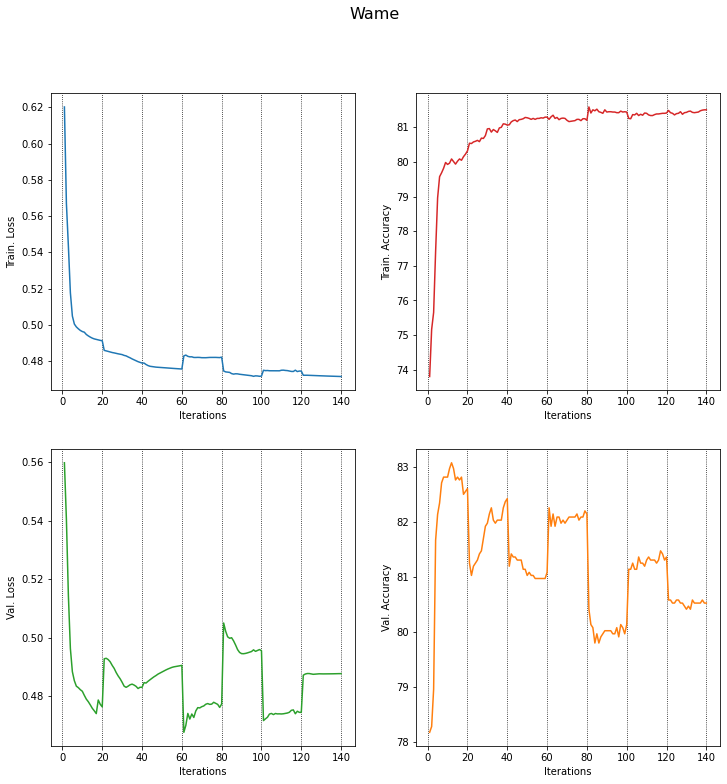

In [18]:
visualise_board(log, "Wame")